In [ ]:
import jax
import jax.numpy as jnp
from jax import jit
from jax.config import config
config.update("jax_enable_x64", True)

In [6]:
sys.path.append('../jax_healpix/')
from SPHT_jax import *
from Healpy_test_fn import *


In [2]:
nside=32
l_max=nside*3
npix=hp.nside2npix(nside)

In [3]:
z, repeats, fft_phi = hp_pix_trans_i(nside)
fft_phi2, fft_phi22 = get_phi0_beta(nside)
np.isclose(np.unique(fft_phi2), np.unique(fft_phi))


127
True
True


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [4]:
th,phi=hp.pix2ang(nside,jnp.arange(npix))
th2,_=reshape_maps(nside,np.atleast_2d(th))
phi2,_=reshape_maps(nside,np.atleast_2d(phi))

/usr/local/lib/python3.9/dist-packages/jax/_src/numpy/lax_numpy.py:1942: UserWarning: Explicitly requested dtype int requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "zeros")


In [5]:
xx=np.array(th2)==np.array(th2[0,:,0])[None,:,None]
xx.sum(),len(th)


(12288, 12288)

In [6]:
th_unique=th2[0,:,0]
phi0_hp=phi2[0,:,0]

In [7]:
def ring_pol2(nside, ring_i):
    ring_i2 = jnp.where(ring_i <= nside, ring_i, 4 * nside - ring_i)

    phi_0 = jnp.pi / 2 / ring_i2 * 0.5  # j=1
    npix = 4 * ring_i
#     ring_i2 = 0  # FIXME
    beta = 1. - (ring_i2**2) / 3. / nside**2
    beta = jnp.where(ring_i <= nside, beta, beta * -1)
    return jnp.array([phi_0, beta])


def ring_eq2(nside, ring_i):
    s = jnp.where(ring_i % 2 == 0, 1, 2)
    phi_0 = jnp.pi / 2 / nside * (1 - s / 2.0)  # j=1
    npix = 4 * nside
    beta = 4.0 / 3 - 2.0 / 3 * ring_i / nside
    return jnp.array([phi_0, beta])


In [8]:
rings=np.arange(4*nside-1)+1
ring_i=rings
ring_q= jnp.where(
        jnp.logical_or(ring_i < nside, ring_i > 3 * nside),
        ring_pol2(nside, ring_i),
        ring_eq2(nside, ring_i),
    )

In [9]:
phi0=ring_q[0]
beta0=ring_q[1]

beta2=ring_beta(nside)

In [10]:
xx=np.isclose(beta2,np.cos(th_unique))
beta2[np.where(~xx)],np.cos(th_unique[np.where(~xx)])

(DeviceArray([0.], dtype=float32), array([-4.371139e-08], dtype=float32))

In [11]:
xx=np.isclose(phi0,phi0_hp)
phi0[np.where(~xx)],phi0_hp[np.where(~xx)]

(DeviceArray([], dtype=float32), DeviceArray([], dtype=float32))

In [15]:
betas = ring_beta(nside)
ylm = sYLM_recur(l_max=l_max, spin_max=0, beta=betas)

In [16]:

cl=np.ones(nside*3)#/(np.arange(nside*3)+1)
%time hmap=hp.synfast(cl,nside=nside)*0
hmap2,indxs=reshape_maps(nside,np.atleast_2d(hmap))
mask=stack_maps(nside,None)


CPU times: user 477 ms, sys: 17.9 ms, total: 495 ms
Wall time: 12.4 ms


In [17]:
hmap2_i=hmap2[:,mask]
np.all(hmap2_i==hmap)

DeviceArray(True, dtype=bool)

In [18]:
indxs2=jnp.where(indxs>=0,indxs,0)
im=indxs.max()
np.array(indxs2,'int64').sum(), im*(im+1)//2

(75491328, DeviceArray(75491328, dtype=int32))

In [19]:
ii=np.unique(indxs2)
len(hmap),ii.max()

(12288, 12287)

In [20]:
ii_d=np.diff(ii)
np.all(ii_d==1)

True

In [21]:
nside=256

In [22]:
beta=ring_beta(nside)
ylm=sYLM_recur(l_max=l_max,spin_max=0,beta=ring_beta(nside))

In [23]:
#To get the spherical harmonics Ylm or order l,m in healpix format with nside, one does:
l= 97
m=0
amplitude =1 #0.5, 0.5j
alms  = np.zeros(  ((l+1)*(l+2) - (l-m)*(l-m+1))//2 , dtype=complex)
alms[-1] = amplitude
ylm_hp = hp.alm2map(alms, nside=nside, pol=False, sigma=0.0, lmax=l, mmax=m)

In [24]:
ylm2,_=reshape_maps(nside,np.atleast_2d(ylm_hp))

/usr/local/lib/python3.9/dist-packages/jax/_src/numpy/lax_numpy.py:1942: UserWarning: Explicitly requested dtype int requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "zeros")


In [25]:
xx=np.isclose(ylm[0][l,m,:],ylm2[0,:,0])
np.all(xx)

False

In [26]:
rr=ylm[0][l,m,:]/ylm2[0,:,0]
rr[~xx].max(),rr[~xx].min()

(DeviceArray(1.6749728e+14, dtype=float32),
 DeviceArray(-158.69946, dtype=float32))

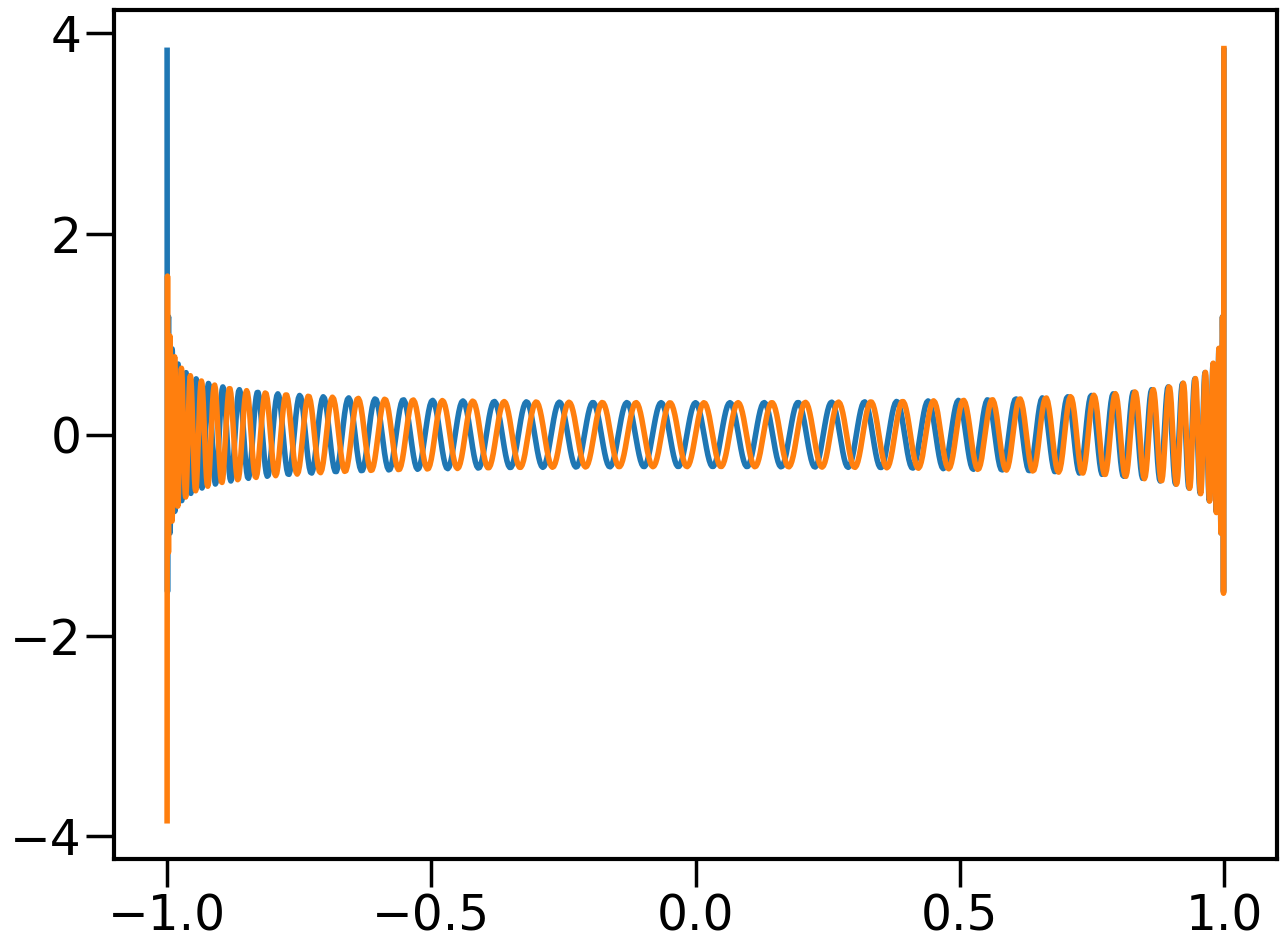

In [27]:
plot(beta,ylm[0][l,m,:])
plot(beta,ylm2[0,:,0])

In [45]:
nside = 32
l_max = int(nside * 3.0)  # setting l_max=nside gives better agreement.
npix = hp.nside2npix(nside)

# Generate healpix map with only one non-zero pixel
hmap = np.zeros(npix)
hmap[0] = 1

# alm from healpy
alm_hp = hp.map2alm(
    hmap, lmax=l_max, iter=0, use_weights=False, use_pixel_weights=False
)  # no iteration, no pixel weights
l_alm, m_alm = hp.Alm.getlm(lmax=l_max)

# https://stackoverflow.com/questions/65844496/healpy-getting-spherical-harmonics-from-as-function-of-pixel-l-and-m
# Use method from above link to get Ylm and then compute Alm.
l = nside*2
m = 1

amplitude = 0.5  # 0.5, 0.5j
alms = np.zeros(((l + 1) * (l + 2) - (l - m) * (l - m + 1)) // 2, dtype=complex)
alms[-1] = amplitude
ylm_hp_real = hp.alm2map(alms, nside=nside, pol=False, sigma=0.0, lmax=l, mmax=m)
alm_real = (ylm_hp_real @ hmap) * hp.nside2pixarea(nside)

alms[-1] = amplitude * 1j
ylm_hp_imag = hp.alm2map(alms, nside=nside, pol=False, sigma=0.0, lmax=l, mmax=m)
alm_imag = 1j * (ylm_hp_imag @ hmap) * hp.nside2pixarea(nside)


x = np.logical_and( l_alm == l, m_alm == m )  # to identify alm corresponding to (l,m) in alm_hp array

print("alm computed here: ", alm_real + alm_imag)
print("healpy alm: ", alm_hp[x])

print("Ratio, real part: ", alm_real / np.real(alm_hp[x]))
print("Ratio, imag part: ", np.imag(alm_imag) / np.imag(alm_hp[x]))

alm computed here:  (-0.0013299749296936997+0.0013299749296936995j)
healpy alm:  [-0.00132997+0.00132997j]
Ratio, real part:  [1.]
Ratio, imag part:  [1.]
